<a href="https://colab.research.google.com/github/wdoppenberg/art-deep-transfer-learning/blob/master/SaliencyMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saliency maps for VGG19, ResNet50 and EfficientNet-b7 trained on Art 

By [Jasper Veen](https://www.linkedin.com/in/jasper-veen), [Bruno Martens](https://www.linkedin.com/in/brunomartens), [Max Hermans](https://www.linkedin.com/in/max-hermans-8324b0b1), and [Wouter Doppenberg](https://www.linkedin.com/in/wouterdoppenberg)

Delft University of Technology, the Netherlands
<br></br>

---




Original Paper by: Matthia Sabatelli, Mike Kestemont, Walter Daelemans, and Pierre Geurts

Université de Liège, Belgium

Universiteit Antwerpen, Belgium

[Original study's repository](https://github.com/paintception/Deep-Transfer-Learning-for-Art-Classification-Problems)

[Original paper](https://www.researchgate.net/publication/327498843_Deep_Transfer_Learning_for_Art_Classification_Problems)

## Setup

Adjust the variables to adjust the notebook to the desired experiment type, and make sure to *run* the following cell before continuing. 

* `WORKSPACE_PATH` , `str` : Path of workspace folder relative from Google Drive root you wish to execute this notebook from, also serves as root folder for `CHECKPOINT_PATH` and `DATASETS_PATH`.
* `CHECKPOINT_PATH`, `str` : Base path to store the model checkpoint files.
* `DATASETS_PATH`, `str` : Base path pointing to the dataset files. Expecting HDF5 files, split into `training_images.hdf5`, `training_labels_creator.hdf5`, `testing_images.hdf5`, `testing_labels_creator.hdf5`, `validation_images.hdf5`, `validation_labels_creator.hdf5` or similar (dependent on dataset / challenge).
* `CHALLENGE`, `str` : The challenge to attempt. Challenges 2 and 3 as described in the paper have been implemented, which refer to type and creator classification, respectively.


In [0]:
WORKSPACE_PATH = 'Colab Notebooks/cs4240-project' #@param {type:'string'}
CHECKPOINT_PATH = 'models/PyTorch/' #@param {type:'string'}
DATASETS_PATH = 'datasets/CR76/' #@param {type:'string'}
CHALLENGE = 'type' #@param ['material', 'type', 'creator'] {type:'string'}
WORKSPACE_PATH = '/content/drive/My Drive/'+WORKSPACE_PATH

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd $WORKSPACE_PATH

/content/drive/My Drive/Colab Notebooks/cs4240-project


In [0]:
pip install -q -r requirements.txt

     |████████████████████████████████| 7.8MB 2.5MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
from pathlib import Path
import random
import time

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.optim import SGD
import h5py
import utils

# Test Set Dataloader


In [0]:

test_path = DATASETS_PATH+'testing.hdf5'


input_size = 224
batch_size = 32

labels = {
    'material':'material_cat',
    'type':'type_cat',
    'creator':'creator_fullname_cat'
}

classes = {
    'material':128,
    'type':534,
    'creator':6620
}

num_classes = classes[CHALLENGE]

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalize = UnNormalize(norm_mean, norm_std)

TensorToImage = transforms.ToPILImage(mode='RGB')

class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, path, challenge):
        self.f = h5py.File(path, 'r')

        self.n_images = len(self.f['images'])
        self.challenge = challenge

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (
            transform(
                Image.open(
                    io.BytesIO(self.f['images'][idx])
                ).convert('RGB')
            ),
            int(self.f[self.challenge][idx])
        )
    
    def random(self):
        return self.__getitem__(
            random.randint(0, self.n_images)
        )

    def __len__(self):
        return self.n_images

test_dataset = HDF5Dataset(test_path, labels[CHALLENGE])


test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=1, 
                                        shuffle=True)


# Load Base Models

In [0]:
from efficientnet_pytorch import EfficientNet

num_classes_dict = {}
num_classes_dict['type'] = 534 #number of classes for the challenge type
num_classes_dict['creator'] = 6620 #"" for the challenge creator
num_classes_dict['material'] = 128 #"" for the challenge material

challenges = ['type', 'creator', 'material']
i = 0
base_models = {}
for challenge in challenges:
    num_classes = num_classes_dict[challenge]
    VGG19_FineTuning_Rijks = models.vgg19(pretrained=True)
    VGG19_FineTuning_Rijks.classifier[6] = nn.Linear(4096, num_classes)

    VGG19_OffTheShelf = models.vgg19(pretrained=False)
    VGG19_OffTheShelf.classifier[6] = nn.Linear(4096, num_classes)

    ResNet50_FineTuning_Rijks = models.resnet50(pretrained=True)
    ResNet50_FineTuning_Rijks.fc = nn.Linear(2048, num_classes)

    ResNet50_OffTheShelf_Rijks = models.resnet50(pretrained=False)
    ResNet50_OffTheShelf_Rijks.fc = nn.Linear(2048, num_classes)

    EfficientNet_b7_FineTuning_Rijks = EfficientNet.from_pretrained('efficientnet-b7')
    EfficientNet_b7_FineTuning_Rijks._fc = nn.Linear(2560, num_classes)

    EfficientNet_b7_OffTheShelf_Rijks = EfficientNet.from_name('efficientnet-b7')
    EfficientNet_b7_OffTheShelf_Rijks._fc = nn.Linear(2560, num_classes)
    base_models[challenge] = [VGG19_FineTuning_Rijks, VGG19_OffTheShelf, ResNet50_FineTuning_Rijks,ResNet50_OffTheShelf_Rijks, EfficientNet_b7_FineTuning_Rijks, EfficientNet_b7_OffTheShelf_Rijks]
    i = i+1



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7


# Import models from checkpoint files

In [0]:
challenge = CHALLENGE
trained_models = {}
base_models_challenge = base_models[challenge]
trained_models_challenge = base_models_challenge
CHECKPOINT_PATH = f'models/PyTorch/{challenge}/'
MODEL_NAMES = ['VGG19_FineTuning_Rijks','VGG19_OffTheShelf_Rijks', 'ResNet50_FineTuning_Rijks','ResNet50_OffTheShelf_Rijks', 'EfficientNet_b7_FineTuning_Rijks', 'EfficientNet_b7_OffTheShelf_Rijks']
i = 0
for model in base_models:    
    checkpoint_path_full = f'{CHECKPOINT_PATH}{MODEL_NAMES[i]}_{challenge}.pth'
   
    if Path(checkpoint_path_full).is_file():
        print(f'Using checkpoint from {checkpoint_path_full}')
        if ~torch.cuda.is_available():
            checkpoint = torch.load(checkpoint_path_full, map_location=torch.device('cpu'))
        else:    
            checkpoint = torch.load(checkpoint_path_full)

        trained_models_challenge[i].load_state_dict(checkpoint['model_state_dict'])
    else:
        print(f'No checkpoint file for {MODEL_NAMES[i]}_{challenge}')
    
    i += 1
trained_models[challenge] = trained_models_challenge

Using checkpoint from models/PyTorch/type/VGG19_FineTuning_Rijks_type.pth
Using checkpoint from models/PyTorch/type/VGG19_OffTheShelf_Rijks_type.pth
Using checkpoint from models/PyTorch/type/ResNet50_FineTuning_Rijks_type.pth


#Import image from test dataset


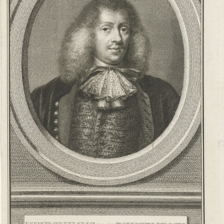

In [0]:
index_image = 910 #224, 162, 1331
image, label = test_dataset[index_image]
TensorToImage(unnormalize(image.cpu()))

#Saliency Maps Computations

In [0]:
image, label = test_dataset[index_image]

image.unsqueeze_(0)
image.requires_grad_()

num_classes = num_classes_dict[challenge]
VGG19_FineTuning_Rijks = models.vgg19(pretrained=True)
VGG19_FineTuning_Rijks.classifier[6] = nn.Linear(4096, num_classes)

ResNet50_FineTuning_Rijks = models.resnet50(pretrained=True)
ResNet50_FineTuning_Rijks.fc = nn.Linear(2048, num_classes)

EfficientNet_b7_FineTuning_Rijks = EfficientNet.from_pretrained('efficientnet-b7')
EfficientNet_b7_FineTuning_Rijks._fc = nn.Linear(2560, num_classes)

models_list = [VGG19_FineTuning_Rijks, ResNet50_FineTuning_Rijks, EfficientNet_b7_FineTuning_Rijks]
saliencies_base_list = []
for model in models_list:    
 
    model.eval()

    logits = model(image)
    #loss = loss_function(logits, label.argmax(dim=1))
    print(logits.argmax(dim=1))

    score_max_index = logits.argmax(dim=1)
    score_max = logits[0, score_max_index]

    score_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliencies_base_list.append(saliency)
saliency_VGG19_PT = saliencies_base_list[0]
saliency_ResNet_PT= saliencies_base_list[1]
saliency_Eff_PT= saliencies_base_list[2]

Loaded pretrained weights for efficientnet-b7
tensor([223])
tensor([360])
tensor([178])


Interesting sample: #12334

In [0]:

saliency_maps = {}
saliency_maps_challenge = []
for model in trained_models[challenge]:    
    image, label = test_dataset[index_image]
    model = model
  
    image.unsqueeze_(0)
    image.requires_grad_()
    
    model.eval()

    image.requires_grad_()

    logits = model(image)
    #loss = loss_function(logits, label.argmax(dim=1))
    print(logits.argmax(dim=1))

    score_max_index = logits.argmax(dim=1)
    score_max = logits[0, score_max_index]

    score_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency_maps_challenge.append(saliency)

saliency_maps[challenge] = saliency_maps_challenge

tensor([341])
tensor([341])
tensor([341])
tensor([136])
tensor([86])
tensor([124])


#Saliency Maps Visualisation

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

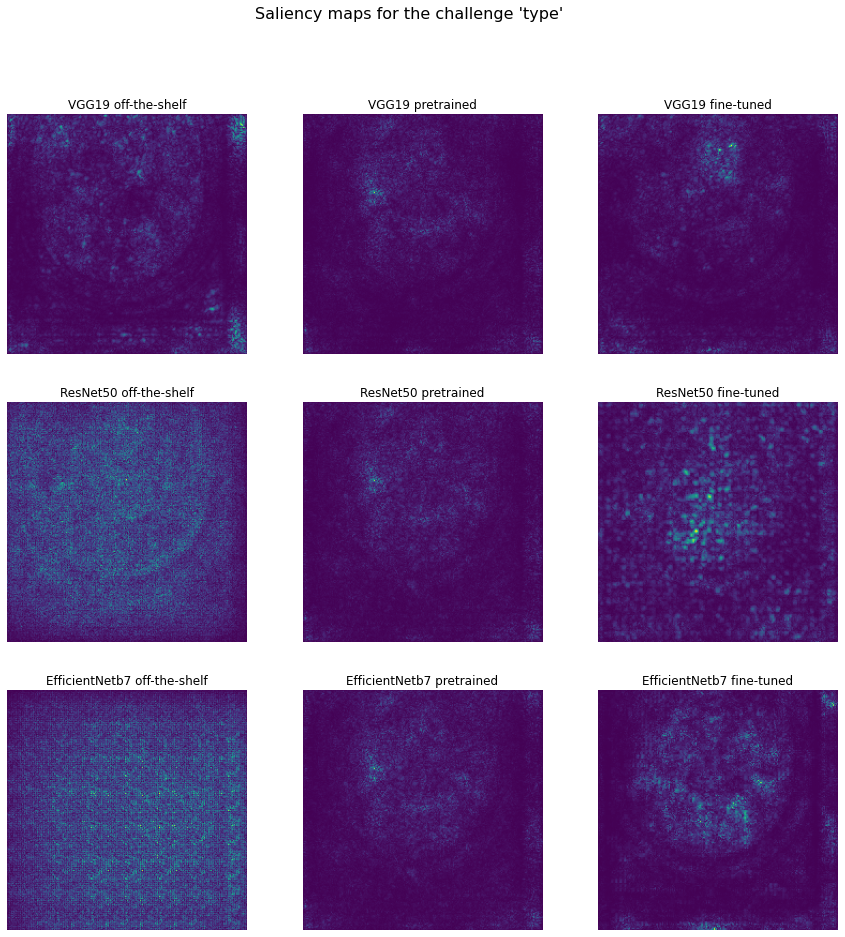

In [0]:

saliency_maps_list = saliency_maps[challenge]

fig, (ax1, ax2, ax3) = plt.subplots(3,3,figsize=(15, 15))
fig.suptitle(f"Saliency maps for the challenge '{challenge}'", fontsize=16) 

print(saliency_VGG19_PT.shape)
ax1[1].imshow(saliency_VGG19_PT[0])
ax1[1].set_title('VGG19 pretrained')
ax1[1].set(ylabel='VGG19')
ax1[1].axis('off')

print(saliency_maps_list[0].shape)
ax1[2].imshow(saliency_maps_list[0][0])
ax1[2].set_title('VGG19 fine-tuned')
ax1[2].axis('off')

ax1[0].imshow(saliency_maps_list[1][0])
ax1[0].set_title('VGG19 off-the-shelf')
ax1[0].axis('off')

ax2[1].imshow(saliency_ResNet_PT[0])
ax2[1].set_title('ResNet50 pretrained')
ax2[1].axis('off')

ax2[2].imshow(saliency_maps_list[2][0])
ax2[2].set_title('ResNet50 fine-tuned')
ax2[2].axis('off')

ax2[0].imshow(saliency_maps_list[3][0])
ax2[0].set_title('ResNet50 off-the-shelf')
ax2[0].axis('off')

ax3[1].imshow(saliency_Eff_PT[0])
ax3[1].set_title('EfficientNetb7 pretrained')
ax3[1].axis('off')

ax3[2].imshow(saliency_maps_list[4][0])
ax3[2].set_title('EfficientNetb7 fine-tuned')
ax3[2].axis('off')

ax3[0].imshow(saliency_maps_list[5][0])
ax3[0].set_title('EfficientNetb7 off-the-shelf')
ax3[0].axis('off')